# **Problem Statement**

- Ninjacart is India's largest fresh produce supply chain company. They are pioneers in solving one of the toughest supply chain problems of the world by leveraging innovative technology.
- They source fresh produce from farmers and deliver them to businesses within 12 hours.
- An integral component of their automation process is the `development of robust classifiers which can distinguish between images of different types of vegetables`, while also `correctly labeling images that do not contain any one type of vegetable as noise.`



- As a starting point, ninjacart has provided us with a dataset scraped from the web which contains train and test folders, each having 4 sub-folders with images of onions, potatoes, tomatoes and some market scenes.
- We have been tasked with preparing a multiclass classifier for identifying these vegetables. The dataset provided has all the required images to achieve the task.

## **Context**

- This dataset contains images of the following food items: noise-Indian market and images of vegetables- onion, potato and tomato.

## **Data Collection**

- The images in this dataset were scraped from Google.

## **Content**

- This dataset contains a folder train, which has a total of 3135 images, split into four folders as follows:

  - Tomato : 789

  - Potato : 898

  - Onion : 849

  - Indian market : 599

- This dataset contains another folder test which has a total of 351 images, split into four folders

  - Tomato : 106

  - potato : 83

  - onion : 81

  - Indian market : 81

## **Objective :**

- The objective is to develop a program that can recognize the vegetable item(s) in a photo and identify them for the user.

### **Concepts Tested**:

- Dataset Preparation & Visualization

- CNN models

- Implementing Callbacks

- Deal with Overfitting

- Transfer Learning

# Downloading Data

In [1]:
import gdown

In [2]:
url = "https://drive.google.com/file/d/1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT/view?usp=sharing"
output = "/content/drive/MyDrive/data.zip"
gdown.download(url=url, output=output, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT
From (redirected): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT&confirm=t&uuid=4aa0912f-0ac8-4931-8377-e0b6a1eefddf
To: /content/drive/MyDrive/data.zip
100%|██████████| 275M/275M [00:01<00:00, 175MB/s]


'/content/drive/MyDrive/data.zip'

In [3]:
!unzip /content/drive/MyDrive/data.zip

Archive:  /content/drive/MyDrive/data.zip
   creating: ninjacart_data/test/
   creating: ninjacart_data/test/indian market/
  inflating: ninjacart_data/test/indian market/bhl.jpeg  
  inflating: ninjacart_data/test/indian market/bhv.jpeg  
  inflating: ninjacart_data/test/indian market/bn.jpeg  
  inflating: ninjacart_data/test/indian market/hjx.jpeg  
  inflating: ninjacart_data/test/indian market/igis.jpeg  
  inflating: ninjacart_data/test/indian market/in.jpeg  
  inflating: ninjacart_data/test/indian market/india-4898453__340.jpg  
  inflating: ninjacart_data/test/indian market/indianmarket10.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket12.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket13.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket14.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket15.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket18.jpeg  
  inflating: ninjacart_data/test/indian mar

 # Importing libraries


In [4]:
import os
import random
import glob
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
tf.keras.utils.set_random_seed(111)
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.metrics import classification_report, confusion_matrix

# To supress any warnings during the flow
import warnings
warnings.filterwarnings('ignore')

# **Loading & Splitting data in Train, Validation & Test & Resizing**

In [5]:
def load_data(base_dir="/content/drive/MyDrive/ninjacart_data"):
    # checking if the data folders are present
    assert os.path.exists(f"{base_dir}/train") and os.path.exists(f"{base_dir}/test")

    print('\nLoading Data...')
    img_size = (256,256) # set the desired image size for your model

    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
    train_data = image_generator.flow_from_directory(directory=f"{base_dir}/train",
                                                     target_size=img_size, batch_size=32, subset='training', shuffle=True, class_mode='categorical')

    val_data = image_generator.flow_from_directory(directory=f"{base_dir}/train",
                                                   target_size=img_size, batch_size=32, subset='validation', shuffle=False, class_mode='categorical')

    test_data = tf.keras.utils.image_dataset_from_directory(
        f"{base_dir}/test", shuffle=False, label_mode='categorical', batch_size=32, image_size=img_size
    )


    return train_data, val_data, test_data

In [6]:
train_data, val_data, test_data = load_data()


Loading Data...
Found 2511 images belonging to 4 classes.
Found 624 images belonging to 4 classes.
Found 351 files belonging to 4 classes.


# **Train Data Distribution**

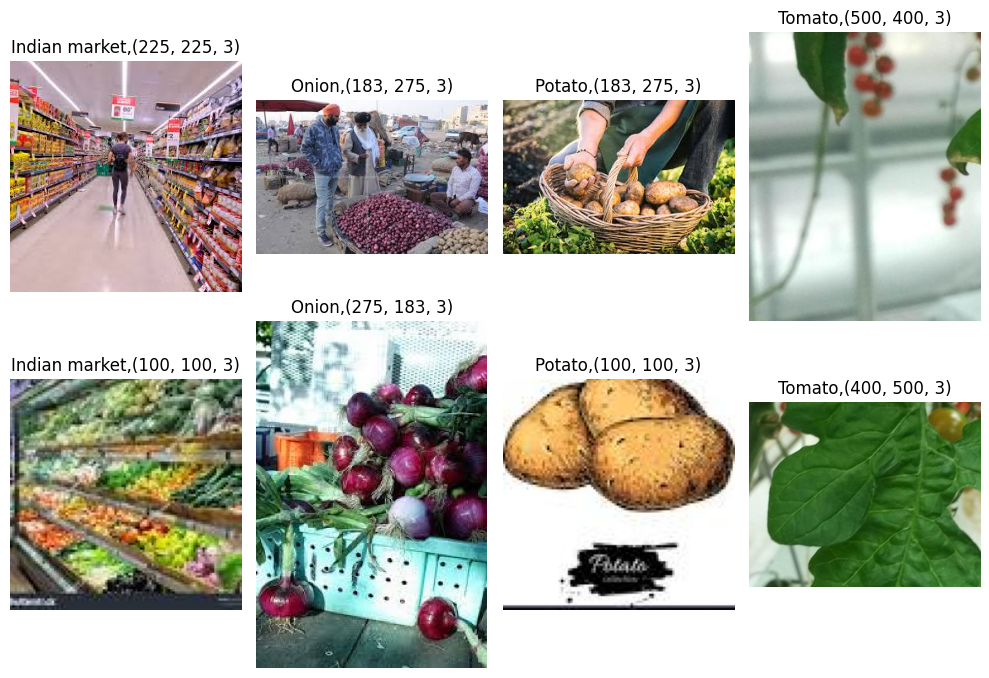

In [7]:
from matplotlib.image import imread

image_list = []
image_dim = []
classes = ["indian_market", "onion", "potato", "tomato"]

for _ in range(2):
  image_list.append(random.choice(glob.glob("/content/ninjacart_data/train/indian market/*")))
  image_list.append(random.choice(glob.glob("/content/ninjacart_data/train/onion/*")))
  image_list.append(random.choice(glob.glob("/content/ninjacart_data/train/potato/*")))
  image_list.append(random.choice(glob.glob("/content/ninjacart_data/train/tomato/*")))

def plot_image_grid(image_list, rows=2, cols=4):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 7))  # Adjust the size of the grid
    axes = axes.flatten()

    for img_path, ax in zip(image_list, axes):
        img = imread(img_path)
        image_dim.append(img.shape)
        class_name = img_path.split("/")[-2]  # Assumes class is the second last part of the path
        ax.set_title(f'{class_name.capitalize()},{img.shape}')  # Title as class name
        ax.imshow(img)  # Display the image
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the images
plot_image_grid(image_list)

In [8]:
data_path = "/content/ninjacart_data/train/"
classes = ['indian market', 'onion', 'potato', 'tomato']

class_counts = {}

for cls in classes:
    class_path = f"{data_path}{cls}/*"
    image_count = len(glob.glob(class_path))
    class_counts[cls] = image_count

cnt = pd.DataFrame({
    "class": class_counts.keys(),
    "count": class_counts.values(),
})

cnt

class  count
0  indian market    599
1          onion    849
2         potato    898
3         tomato    789

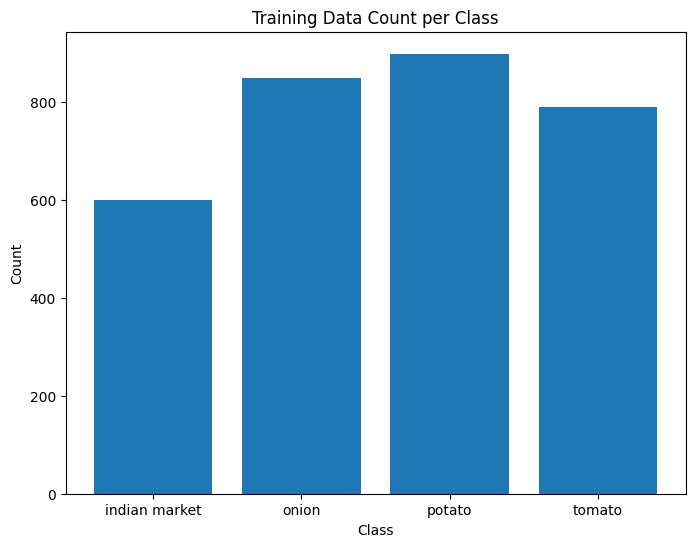

In [9]:
# Plot using matplotlib
plt.figure(figsize=(8, 6))
plt.bar(cnt['class'], cnt['count'])

# Add title and labels
plt.title("Training Data Count per Class")
plt.xlabel("Class")
plt.ylabel("Count")

# Show the plot
plt.show()

# **Test Data Distribution**

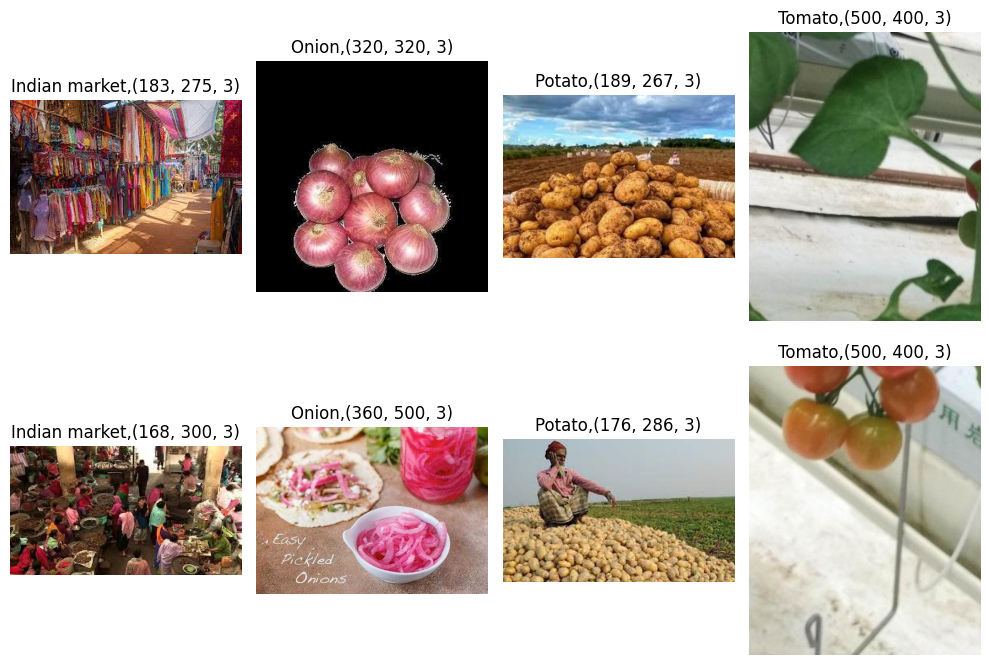

In [10]:
from matplotlib.image import imread

image_list = []
image_dim = []
classes = ["indian_market", "onion", "potato", "tomato"]

for _ in range(2):
  image_list.append(random.choice(glob.glob("/content/ninjacart_data/test/indian market/*")))
  image_list.append(random.choice(glob.glob("/content/ninjacart_data/test/onion/*")))
  image_list.append(random.choice(glob.glob("/content/ninjacart_data/test/potato/*")))
  image_list.append(random.choice(glob.glob("/content/ninjacart_data/test/tomato/*")))

def plot_image_grid(image_list, rows=2, cols=4):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 7))  # Adjust the size of the grid
    axes = axes.flatten()

    for img_path, ax in zip(image_list, axes):
        img = imread(img_path)
        image_dim.append(img.shape)
        class_name = img_path.split("/")[-2]  # Assumes class is the second last part of the path
        ax.set_title(f'{class_name.capitalize()},{img.shape}')
        ax.imshow(img)  # Display the image
        ax.axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

# Visualize the images
plot_image_grid(image_list)

In [11]:
data_path = "/content/ninjacart_data/test/"
classes = ['indian market', 'onion', 'potato', 'tomato']

class_counts = {}

for cls in classes:
    class_path = f"{data_path}{cls}/*"
    image_count = len(glob.glob(class_path))
    class_counts[cls] = image_count

cnt = pd.DataFrame({
    "class": class_counts.keys(),
    "count": class_counts.values(),
})

cnt

class  count
0  indian market     81
1          onion     83
2         potato     81
3         tomato    106

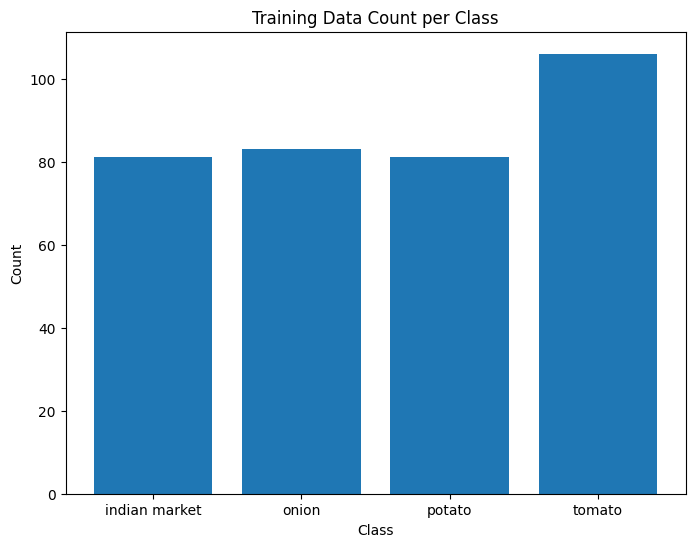

In [12]:
# Plot using matplotlib
plt.figure(figsize=(8, 6))
plt.bar(cnt['class'], cnt['count'])

# Add title and labels
plt.title("Training Data Count per Class")
plt.xlabel("Class")
plt.ylabel("Count")

# Show the plot
plt.show()

# **Model Architecture**

In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(256, 256, 3)),

    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(4, activation='softmax')
])

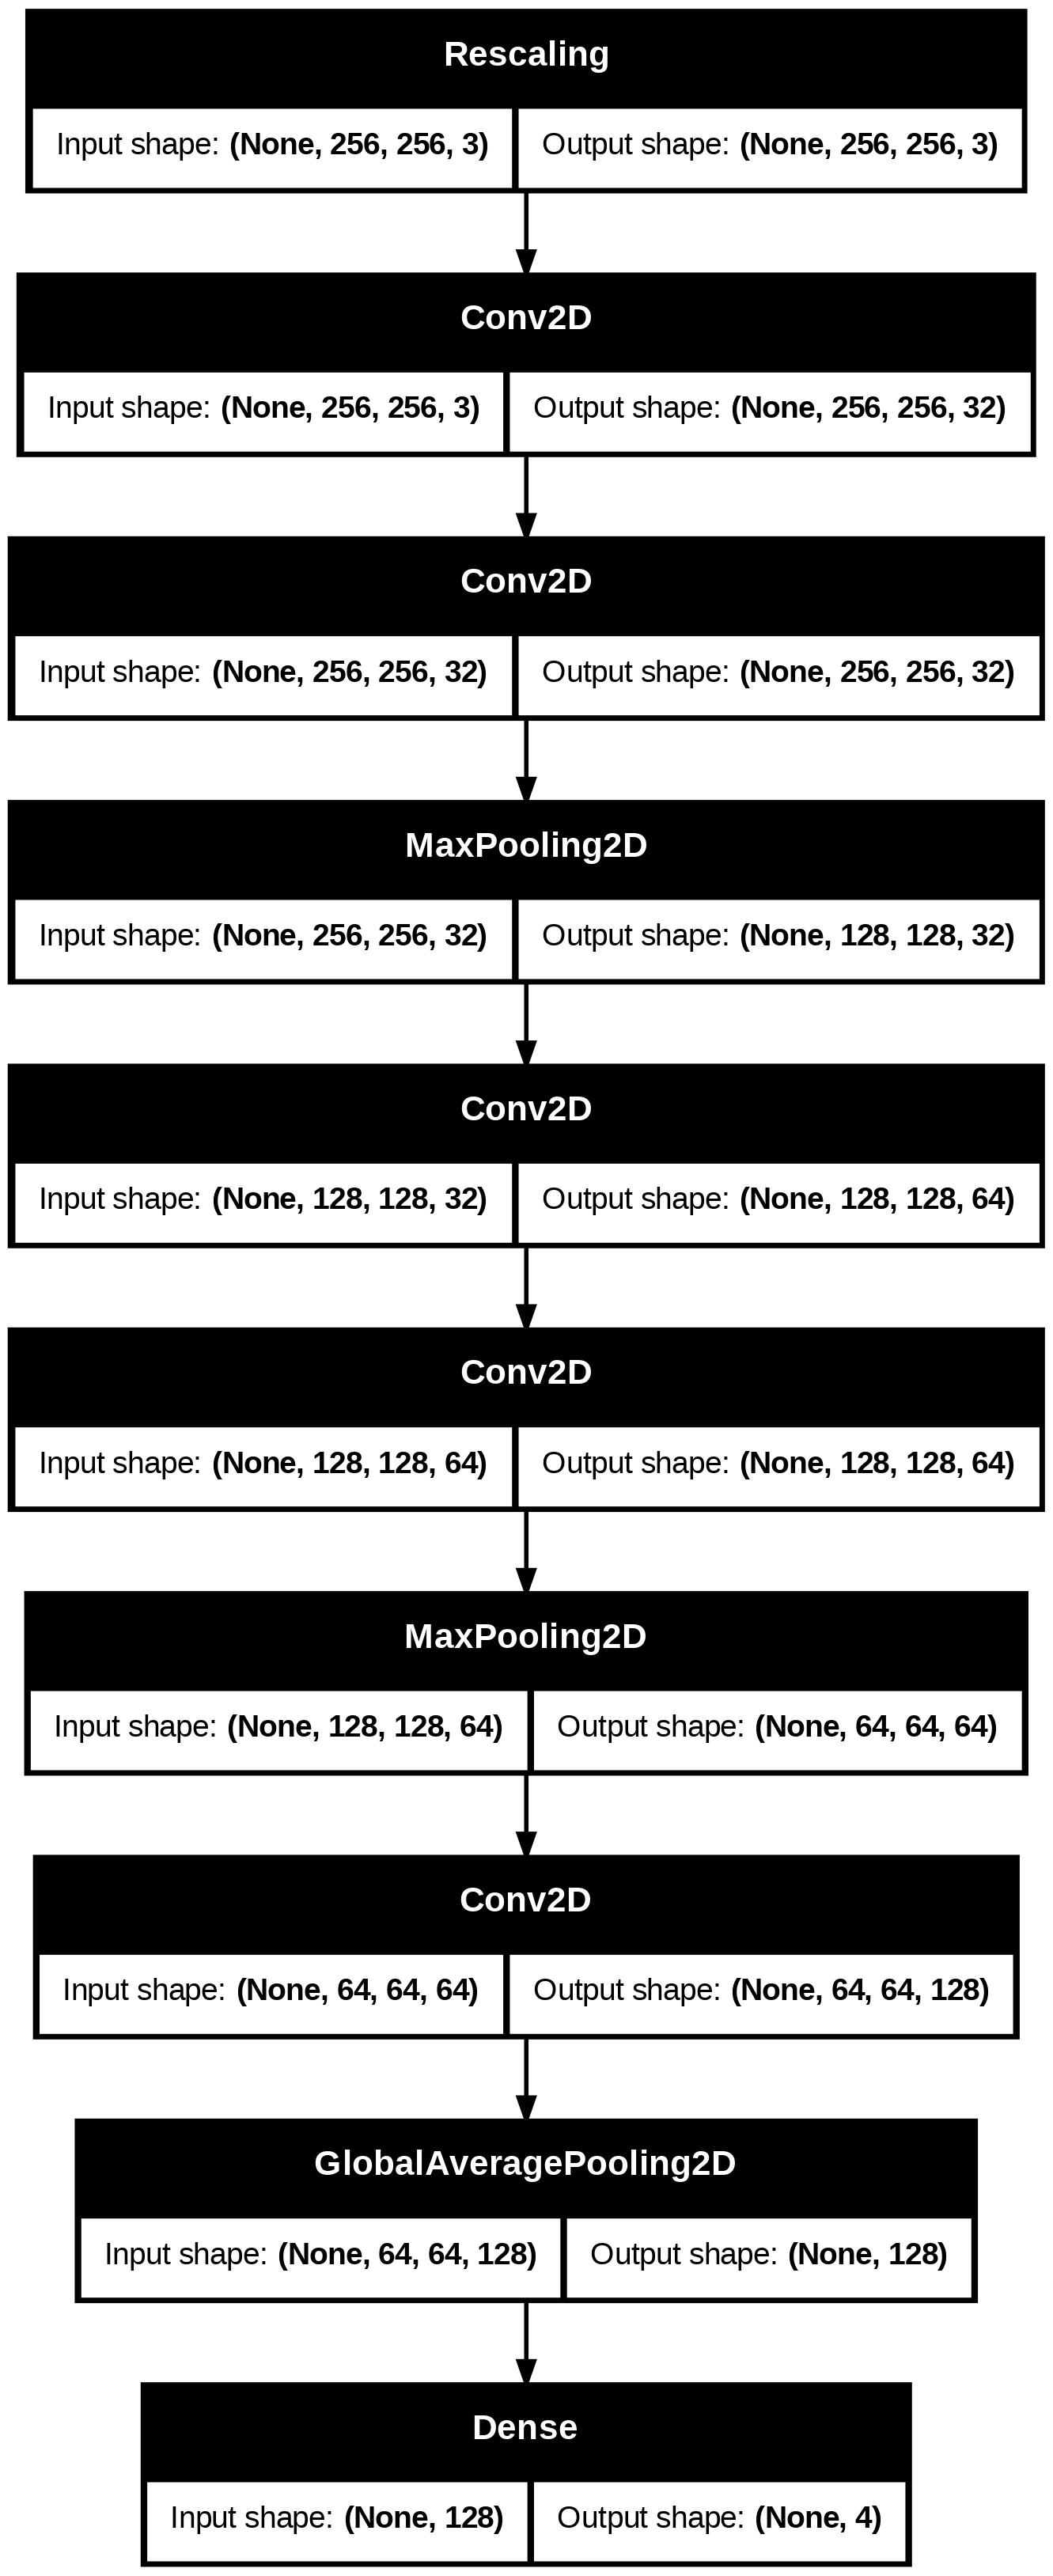

In [40]:
tf.keras.utils.plot_model(model, to_file="model_cnn.png", show_shapes=True)

In [41]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 139,940 (546.64 KB)

 Trainable params: 139,940 (546.64 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Compile & Fit the model
checkpoint = tf.keras.callbacks.ModelCheckpoint("cnn1.keras", save_best_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=4, restore_best_weights = True )

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])

In [44]:
# Fitting the Model : Long Time to execute
model_history = model.fit(train_data, validation_data=val_data,
                          epochs=20, verbose=1,
                          callbacks=[early_stop, checkpoint])

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 68s 608ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.2516 - loss: 1.3860 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.2869 - val_loss: 1.3834
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 332ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.2776 - loss: 1.3790 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.2869 - val_loss: 1.3758
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 31s 374ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.2754 - loss: 1.3758 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.2869 - val_loss: 1.3739
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 386ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.2901 - loss: 1.3730 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.2869 - val_loss: 1.3721
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 296ms/step - Precision: 0.0000e+00 - Recall: 0.000

In [ ]:
model.save('/content/drive/MyDrive/ninjacart_data/cnn_model.keras')

In [13]:
model = keras.models.load_model('/content/drive/MyDrive/ninjacart_data/cnn_model.keras')

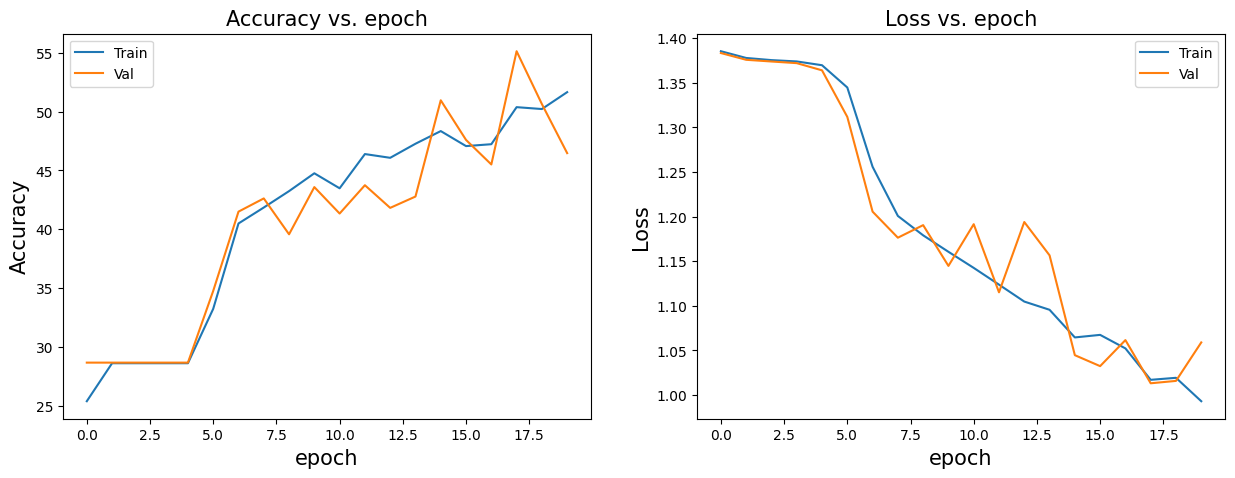

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))
ax = axes .ravel()

#accuracy graph
ax[0].plot(range(0,len(model_history.history['accuracy'])), [acc * 100 for acc in model_history.history['accuracy']], label='Train')
ax[0].plot(range(0,len(model_history.history['val_accuracy'])), [acc * 100 for acc in model_history.history['val_accuracy']], label='Val')
ax[0].set_title('Accuracy vs. epoch', fontsize=15)
ax[0].set_ylabel('Accuracy', fontsize=15)
ax[0].set_xlabel('epoch', fontsize=15)
ax[0].legend()

#loss graph
ax[1].plot(range(0,len(model_history.history['loss'])), model_history.history['loss'], label='Train')
ax[1].plot(range(0,len(model_history.history['val_loss'])), model_history.history['val_loss'], label='Val')
ax[1].set_title('Loss vs. epoch', fontsize=15)
ax[1].set_ylabel('Loss', fontsize=15)
ax[1].set_xlabel('epoch', fontsize=15)
ax[1].legend()

#display the graph
plt.show()

In [47]:
result = model.evaluate(test_data)
dict(zip(model.metrics_names,np.round(result,3)))

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - Precision: 0.1438 - Recall: 0.1438 - accuracy: 0.1438 - loss: 173.1912


{'loss': 199.114, 'compile_metrics': 0.231}

In [ ]:
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y for x, y in test_data], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

class_labels = list(test_data.class_names)
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_labels))

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 303ms/step
Classification Report:
               precision    recall  f1-score   support

indian market       0.79      0.42      0.55        81
        onion       0.46      0.67      0.55        83
       potato       0.46      0.78      0.58        81
       tomato       1.00      0.46      0.63       106

     accuracy                           0.58       351
    macro avg       0.68      0.58      0.58       351
 weighted avg       0.70      0.58      0.58       351



In [ ]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrix

array([[34, 39,  8,  0],
       [ 2, 56, 25,  0],
       [ 2, 16, 63,  0],
       [ 5, 11, 41, 49]])

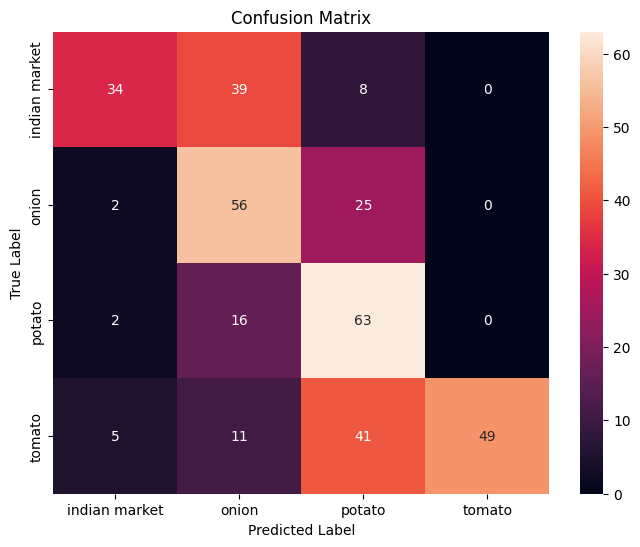

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# **Modification #1**

In [ ]:
def architecture_2(height=256, width=256,num_classes=4):
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn_3",
        layers=[
            layers.Conv2D(filters=16,kernel_size=3,padding="same",input_shape=(height, width, 3),kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.MaxPooling2D(),

            layers.Conv2D(filters=32, kernel_size=3, padding="same",kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.MaxPooling2D(),

            layers.Conv2D(filters=64, kernel_size=3, padding="same", kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.MaxPooling2D(),

            layers.Conv2D(filters=128, kernel_size=3, padding="same",kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.GlobalAveragePooling2D(),

            layers.Dense(units=hidden_size, kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.Dropout(0.2),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [ ]:
model_2 = architecture_2()
model_2.summary()

Model: "model_cnn_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 256, 256, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 256, 256, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 128, 128, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131,492 (513.64 KB)

 Trainable params: 131,492 (513.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def compile_train_v2(model, train_ds, val_ds, epochs=5, ckpt_path="/content/drive/MyDrive/ninjacart_data/CustomCNN_revamp_best.keras"):
    # Defining the callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor='val_accuracy', mode='max'),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=5, min_lr=0.00001)
    ]

    # Setting up the Adam optimizer with custom learning rate
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    # Compile the model
    model.compile(optimizer=adam_optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'recall'])

    # Fit the model with the provided dataset and callbacks
    model_cnn_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)

    return model_cnn_fit

In [ ]:
model_fit = compile_train_v2(model_2, train_data, val_data, epochs=10)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 43s 470ms/step - accuracy: 0.2849 - loss: 1.6797 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4087 - val_loss: 1.5465 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 65s 284ms/step - accuracy: 0.5032 - loss: 1.4409 - precision: 0.5843 - recall: 0.0378 - val_accuracy: 0.5433 - val_loss: 1.2123 - val_precision: 0.8883 - val_recall: 0.2676 - learning_rate: 1.0000e-04
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 285ms/step - accuracy: 0.6271 - loss: 1.1131 - precision: 0.8576 - recall: 0.3601 - val_accuracy: 0.6218 - val_loss: 1.0888 - val_precision: 0.7478 - val_recall: 0.4087 - learning_rate: 1.0000e-04
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 277ms/step - accuracy: 0.6891 - loss: 0.9754 - precision: 0.8156 - recall: 0.5306 - val_accuracy: 0.6811 - val_loss: 1.0058 - val_precision: 0.7609 - val_recall: 0.5609 - learning_rate: 1.0000e-04
Epoch 5/10
79/79 ━━━━━━━━━━━

In [ ]:
model_2.save('/content/drive/MyDrive/ninjacart_data/cnn_model_2.keras')

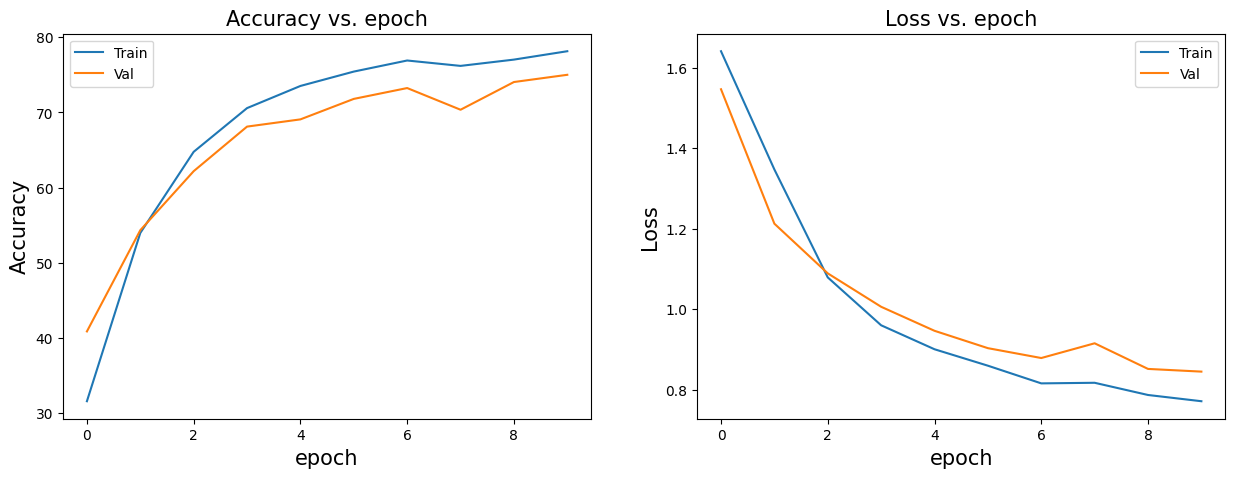

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))
ax = axes.ravel()

#accuracy graph
ax[0].plot(range(0,len(model_fit.history['accuracy'])), [acc * 100 for acc in model_fit.history['accuracy']], label='Train')
ax[0].plot(range(0,len(model_fit.history['val_accuracy'])), [acc * 100 for acc in model_fit.history['val_accuracy']], label='Val')
ax[0].set_title('Accuracy vs. epoch', fontsize=15)
ax[0].set_ylabel('Accuracy', fontsize=15)
ax[0].set_xlabel('epoch', fontsize=15)
ax[0].legend()

#loss graph
ax[1].plot(range(0,len(model_fit.history['loss'])), model_fit.history['loss'], label='Train')
ax[1].plot(range(0,len(model_fit.history['val_loss'])), model_fit.history['val_loss'], label='Val')
ax[1].set_title('Loss vs. epoch', fontsize=15)
ax[1].set_ylabel('Loss', fontsize=15)
ax[1].set_xlabel('epoch', fontsize=15)
ax[1].legend()

#display the graph
plt.show()

In [ ]:
result = model_2.evaluate(test_data)
dict(zip(model.metrics_names,np.round(result,3)))

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - accuracy: 0.3491 - loss: 315.2663 - precision: 0.3491 - recall: 0.3491


{'loss': 275.7, 'compile_metrics': 0.439}

In [ ]:
y_pred = model_2.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y for x, y in test_data], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

class_labels = list(test_data.class_names)
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_labels))

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step
Classification Report:
               precision    recall  f1-score   support

indian market       0.33      0.05      0.09        81
        onion       0.30      0.95      0.46        83
       potato       0.62      0.16      0.25        81
       tomato       1.00      0.55      0.71       106

     accuracy                           0.44       351
    macro avg       0.56      0.43      0.38       351
 weighted avg       0.59      0.44      0.40       351



In [ ]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrix

array([[ 4, 77,  0,  0],
       [ 3, 79,  1,  0],
       [ 4, 64, 13,  0],
       [ 1, 40,  7, 58]])

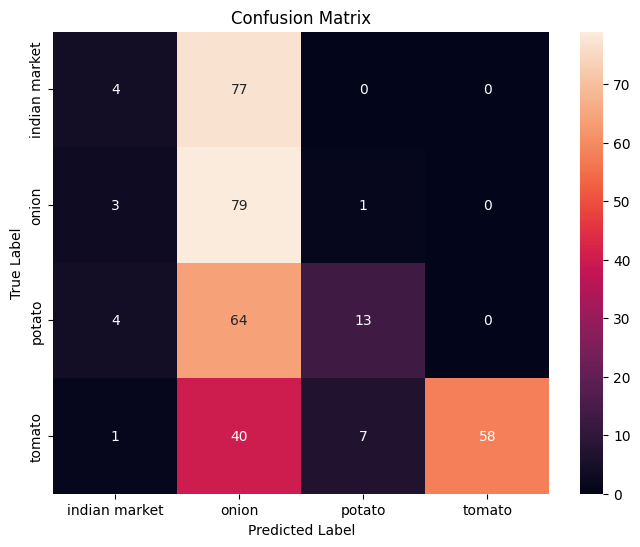

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# **Pre-Trained Models like VGG, ResNet & MobileNet**




In [ ]:
IMG_SIZE = 256
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomTranslation(height_factor = 0.2, width_factor = 0.2),
])

# **VGG19**

In [ ]:
def build_vgg19_model():

    # Instantiate the VGG19 model with the input tensor
    base_model = tf.keras.applications.vgg19.VGG19(
        weights='imagenet', include_top=False, input_shape=(256, 256, 3)
    )
    model = tf.keras.Sequential()
    model.add(layers.Lambda(lambda x: x, input_shape=(256, 256, 3)))
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(4, activation='softmax'))

    base_model.trainable = False  # Freeze the base model layers
    return model

vgg_model = build_vgg19_model()

In [ ]:
vgg_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_3 (Lambda)                    │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 8, 8, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,026,436 (76.39 MB)

 Trainable params: 2,052 (8.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
# Setting Checkpoints
checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/ninjacart_data/vgg19_best.keras", save_best_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, restore_best_weights = True )

#Compile the model
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
vgg_model.compile(optimizer=adam_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

In [ ]:
# Fitting the Model : Long Time to execute
vgg_fit = vgg_model.fit(train_data, validation_data=val_data,
                          epochs=10, verbose=1,
                          callbacks=[early_stop, checkpoint])

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 76s 718ms/step - accuracy: 0.2525 - loss: 1.7143 - precision: 0.2356 - recall: 0.1681 - val_accuracy: 0.2901 - val_loss: 1.4557 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 352ms/step - accuracy: 0.2360 - loss: 1.5206 - precision: 0.1173 - recall: 0.0188 - val_accuracy: 0.2724 - val_loss: 1.3644 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 403ms/step - accuracy: 0.2863 - loss: 1.4070 - precision: 0.2598 - recall: 0.0122 - val_accuracy: 0.3317 - val_loss: 1.3104 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 401ms/step - accuracy: 0.3508 - loss: 1.3369 - precision: 0.3659 - recall: 0.0142 - val_accuracy: 0.4263 - val_loss: 1.2616 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 392ms/step - accuracy: 0.3865 - loss: 1.2946 - precision: 0.4745 - recall: 0.0146 

In [ ]:
vgg_model.save('/content/drive/MyDrive/ninjacart_data/vgg_model.keras')

In [ ]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    metrics = ['loss', 'accuracy']
    for index, key in enumerate(metrics):
        plt.subplot(1,len(metrics),index+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_'+key])
        plt.xlabel("Epochs")
        plt.ylabel(key)
        plt.legend([key, 'val_'+key])
    plt.show()

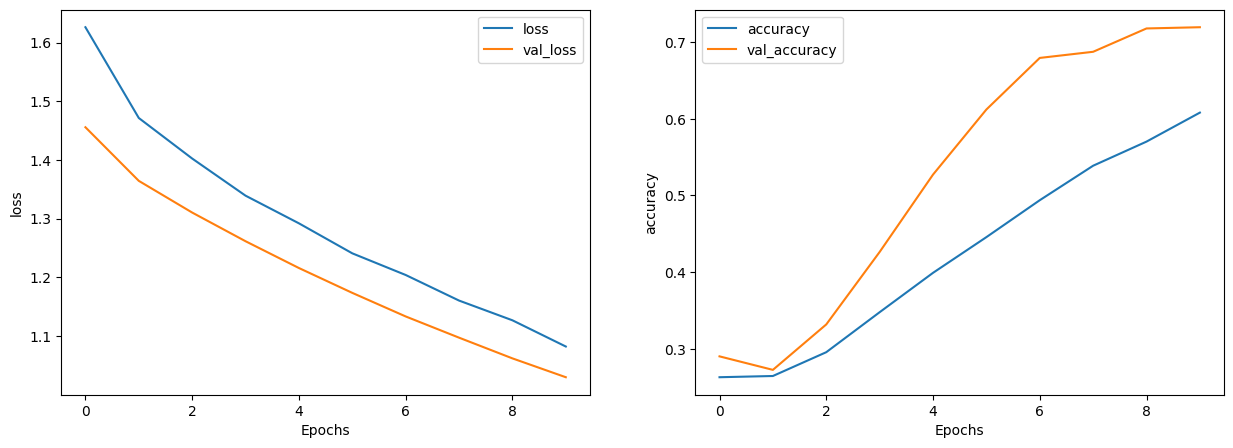

In [ ]:
plot_history(vgg_fit)

In [ ]:
# Loss & Other Metrics from Test Dataset evaluation
result = vgg_model.evaluate(test_data)
dict(zip(model.metrics_names,np.round(result,3)))

11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5412 - loss: 4.8827 - precision: 0.5451 - recall: 0.5360


{'loss': 4.856, 'compile_metrics': 0.49}

In [ ]:
y_pred = vgg_model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y for x, y in test_data], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

class_labels = list(test_data.class_names)
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_labels))

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step
Classification Report:
               precision    recall  f1-score   support

indian market       0.74      0.67      0.70        81
        onion       0.36      0.25      0.30        83
       potato       0.36      0.85      0.51        81
       tomato       1.00      0.26      0.42       106

     accuracy                           0.49       351
    macro avg       0.62      0.51      0.48       351
 weighted avg       0.64      0.49      0.48       351



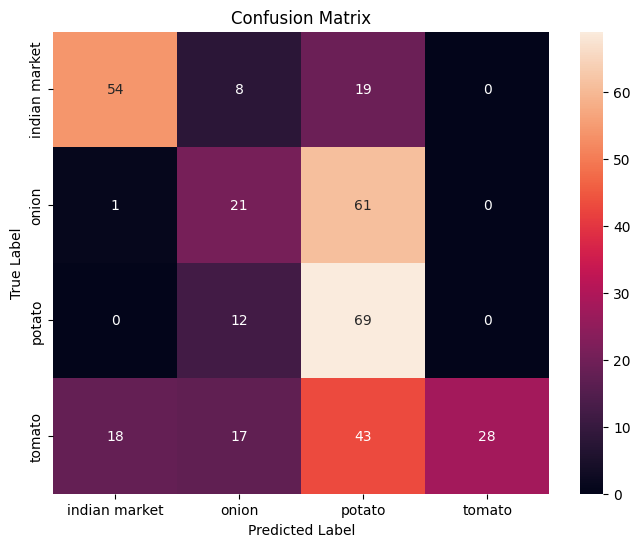

In [ ]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrix

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# **ResNet152**

In [17]:
resnet152 = tf.keras.applications.resnet.ResNet152(weights='imagenet',
                                    include_top=False,
                                    input_shape=(256, 256, 3))

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [18]:
# Set all convolution layer weights as non-trainable
for layer in resnet152.layers:
    layer.trainable = False

# Add a custom output layer
output = tf.keras.layers.GlobalAveragePooling2D()(resnet152.output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(4, activation='softmax')(output)

# Create the transfer learning model
resnet = tf.keras.models.Model(inputs=resnet152.input, outputs=output)

In [19]:
resnet.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 58,379,140 (222.70 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 58,370,944 (222.67 MB)

In [23]:
# Setting Checkpoints
checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/ninjacart_data/resnet152_best.keras", save_best_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, restore_best_weights = True )

#Compile the model
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
resnet.compile(optimizer=adam_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])

In [24]:
# Fitting the Model : Long Time to execute
resnet152_fit = resnet.fit(train_data, validation_data=val_data,
                          epochs=20, verbose=1,
                          callbacks=[early_stop, checkpoint])

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - Precision: 0.1978 - Recall: 0.0267 - accuracy: 0.2375 - loss: 1.5153 - val_Precision: 1.0000 - val_Recall: 0.0016 - val_accuracy: 0.3093 - val_loss: 1.3627
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 77s 461ms/step - Precision: 0.2603 - Recall: 0.0262 - accuracy: 0.2547 - loss: 1.4604 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.2837 - val_loss: 1.3401
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 442ms/step - Precision: 0.3131 - Recall: 0.0361 - accuracy: 0.2867 - loss: 1.4302 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.3349 - val_loss: 1.3182
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 503ms/step - Precision: 0.2734 - Recall: 0.0274 - accuracy: 0.2870 - loss: 1.3981 - val_Precision: 1.0000 - val_Recall: 0.0016 - val_accuracy: 0.3926 - val_loss: 1.3009
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 79s 470ms/step - Precision: 0.3982 - Recall: 0.0302 - accuracy: 0.3243 - loss: 1.3676 - val_Precision: 1

In [ ]:
resnet.save('/content/drive/MyDrive/ninjacart_data/resnet152_model.keras')

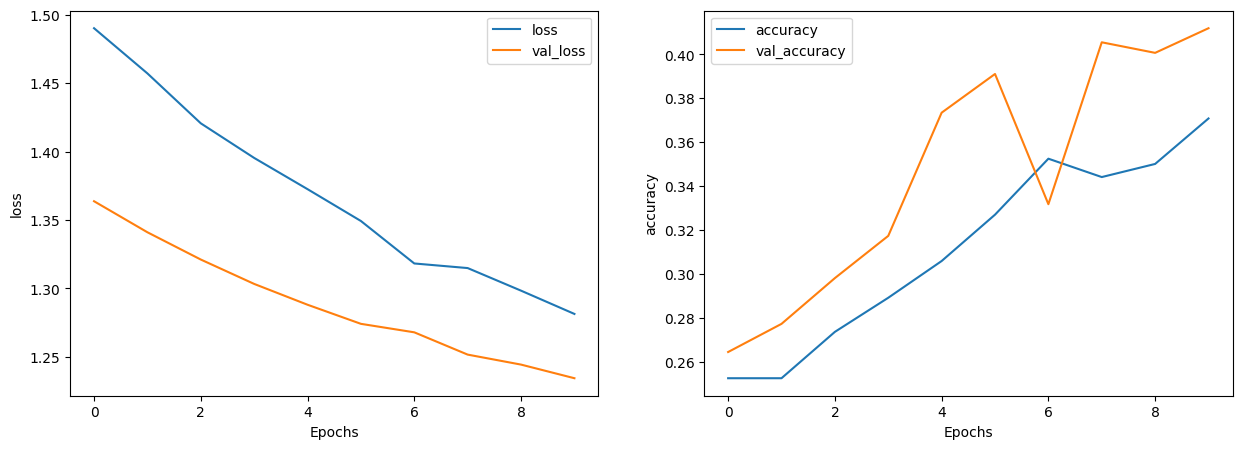

In [ ]:
plot_history(resnet152_fit)

In [25]:
result = resnet.evaluate(test_data)
dict(zip(model.metrics_names,np.round(result,3)))

11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - Precision: 0.3069 - Recall: 0.3069 - accuracy: 0.3069 - loss: 10.5657


{'loss': 8.903, 'compile_metrics': 0.333}

In [26]:
y_pred = resnet.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y for x, y in test_data], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

class_labels = list(test_data.class_names)
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_labels))

11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step
Classification Report:
               precision    recall  f1-score   support

indian market       0.00      0.00      0.00        81
        onion       0.29      0.86      0.43        83
       potato       0.44      0.57      0.50        81
       tomato       0.00      0.00      0.00       106

     accuracy                           0.33       351
    macro avg       0.18      0.36      0.23       351
 weighted avg       0.17      0.33      0.22       351



In [27]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrix

array([[  0,  36,  45,   0],
       [  0,  71,  12,   0],
       [  0,  35,  46,   0],
       [  0, 105,   1,   0]])

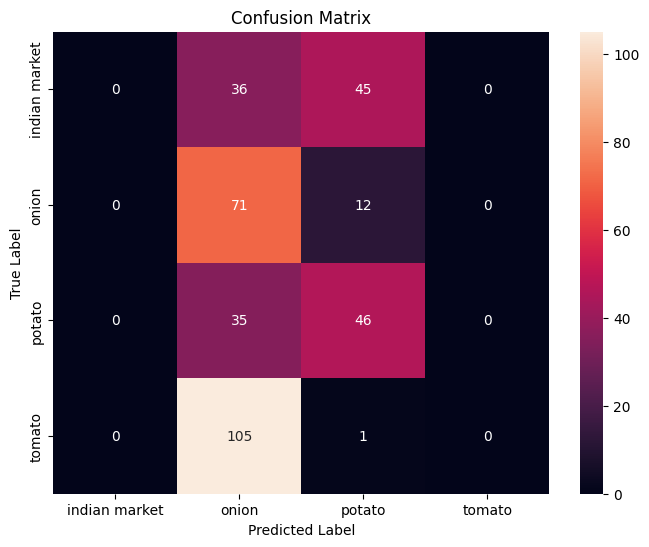

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# **MobileNet**

In [31]:
def build_mobilenet_model():

    # Instantiate the VGG19 model with the input tensor
    base_model = tf.keras.applications.mobilenet.MobileNet(
        weights='imagenet', include_top=False, input_shape=(256, 256, 3)
    )
    model = tf.keras.Sequential()
    model.add(layers.Lambda(lambda x: x, input_shape=(256, 256, 3)))
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(4, activation='softmax'))

    base_model.trainable = False  # Freeze the base model layers
    return model

mob_model = build_mobilenet_model()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
mob_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_5 (Lambda)                    │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenet_1.00_224 (Functional)      │ (None, 8, 8, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,232,964 (12.33 MB)

 Trainable params: 4,100 (16.02 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [ ]:
# Setting Checkpoints
checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/ninjacart_data/mobilenet_best.keras", save_best_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, restore_best_weights = True )

#Compile the model
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
mob_model.compile(optimizer=adam_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])

In [ ]:
# Fitting the Model : Long Time to execute
mobilenet_fit = mob_model.fit(train_data, validation_data=val_data,
                          epochs=20, verbose=1,
                          callbacks=[early_stop, checkpoint])

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 58s 593ms/step - Precision: 0.4260 - Recall: 0.2353 - accuracy: 0.3798 - loss: 1.4493 - val_Precision: 0.7328 - val_Recall: 0.4439 - val_accuracy: 0.6170 - val_loss: 0.9466
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 52s 284ms/step - Precision: 0.6910 - Recall: 0.4572 - accuracy: 0.6010 - loss: 0.9386 - val_Precision: 0.8302 - val_Recall: 0.6426 - val_accuracy: 0.7532 - val_loss: 0.6507
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 291ms/step - Precision: 0.8227 - Recall: 0.6647 - accuracy: 0.7586 - loss: 0.6424 - val_Precision: 0.8710 - val_Recall: 0.7356 - val_accuracy: 0.8269 - val_loss: 0.5007
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 291ms/step - Precision: 0.8731 - Recall: 0.7641 - accuracy: 0.8294 - loss: 0.4972 - val_Precision: 0.8915 - val_Recall: 0.8029 - val_accuracy: 0.8622 - val_loss: 0.4105
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 291ms/step - Precision: 0.8848 - Recall: 0.8046 - accuracy: 0.8536 - loss: 0.4234 - val_Precision: 0.9102 - val_Re

In [ ]:
mob_model.save('/content/drive/MyDrive/ninjacart_data/mobilenet_model.keras')

In [32]:
mob_model.load_weights("/content/drive/MyDrive/ninjacart_data/mobilenet_best.keras")

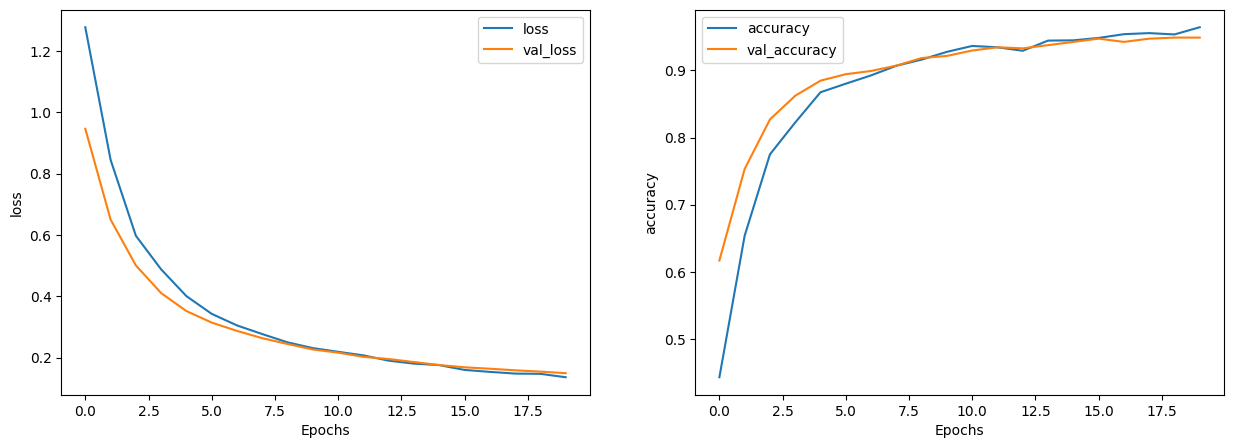

In [ ]:
plot_history(mobilenet_fit)

In [ ]:
result = mob_model.evaluate(test_data)
dict(zip(model.metrics_names,np.round(result,3)))

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 707ms/step - Precision: 0.4936 - Recall: 0.3595 - accuracy: 0.4636 - loss: 1.2422


{'loss': 1.593, 'compile_metrics': 0.345}

In [ ]:
y_pred = mob_model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y for x, y in test_data], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

class_labels = list(test_data.class_names)
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_labels))

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step
Classification Report:
               precision    recall  f1-score   support

indian market       0.47      0.49      0.48        81
        onion       0.29      0.71      0.41        83
       potato       0.00      0.00      0.00        81
       tomato       0.37      0.21      0.27       106

     accuracy                           0.34       351
    macro avg       0.28      0.35      0.29       351
 weighted avg       0.29      0.34      0.29       351



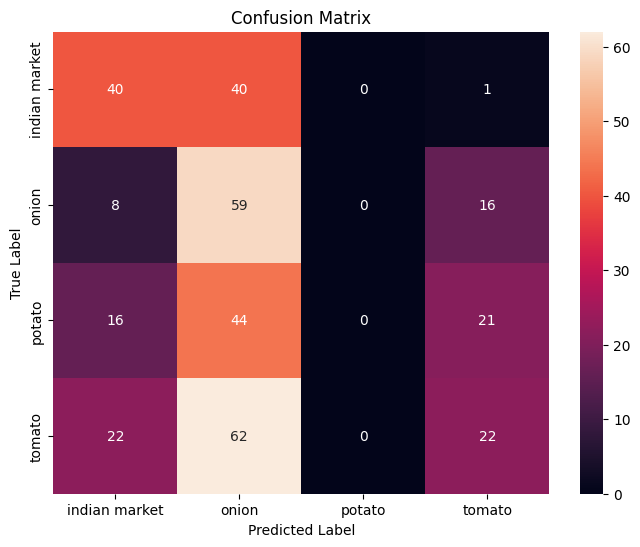

In [ ]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# **Comparision of all Models & Insights**

---

## **CNN**

#### Architecture 1:
    Total params: 139,940
    Trainable params: 139,940
    Non-trainable params: 0

    loss: 0.9809
    accuracy: 0.5017
    precision: 0.7792
    recall: 0.2156



#### Architecture 2:

    Total params: 131,492
    Trainable params: 131,492
    Non-trainable params: 0

    loss: 0.7703
    accuracy: 0.7852
    precision: 0.8286
    recall: 0.7281




-------------

### VGG-19

    Total params: 20,026,436
    Trainable params: 2,052
    Non-trainable params: 20,026,436

    loss: 1.0830
    accuracy: 0.6161
    precision: 0.8305
    recall: 0.0966

-------
### ResNet152

    Total params: 58,379,140
    Trainable params: 8,196
    Non-trainable params: 58,370,944

    loss : 1.2027
    accuracy: 0.4394
    precision: 0.5784
    recall: 0.0730

---
### MobileNet

    Total params: 3,232,964
    Trainable params: 4,100
    Non-trainable params: 3,228,864

    loss : 0.1291
    accuracy: 0.9694
    precision: 0.9753
    recall: 0.9622




> If there are no constraints on Runtime execution time, best option is to use **MobileNet Model** as it has **highest accuracy of 96%**.

> If there are constraints on Runtime execution time, best option is to use **Finetuned CNN Model Architecture 2** as it **good accuracy of 78%.



In [51]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_precision, test_recall = mob_model.evaluate(test_data)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Precision: {test_precision * 100:.2f}%")
print(f"Test Recall: {test_recall * 100:.2f}%")


11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 779ms/step - Precision: 0.4936 - Recall: 0.3595 - accuracy: 0.4636 - loss: 1.2422
Test Loss: 1.5927646160125732
Test Accuracy: 34.47%
Test Precision: 37.55%
Test Recall: 24.50%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


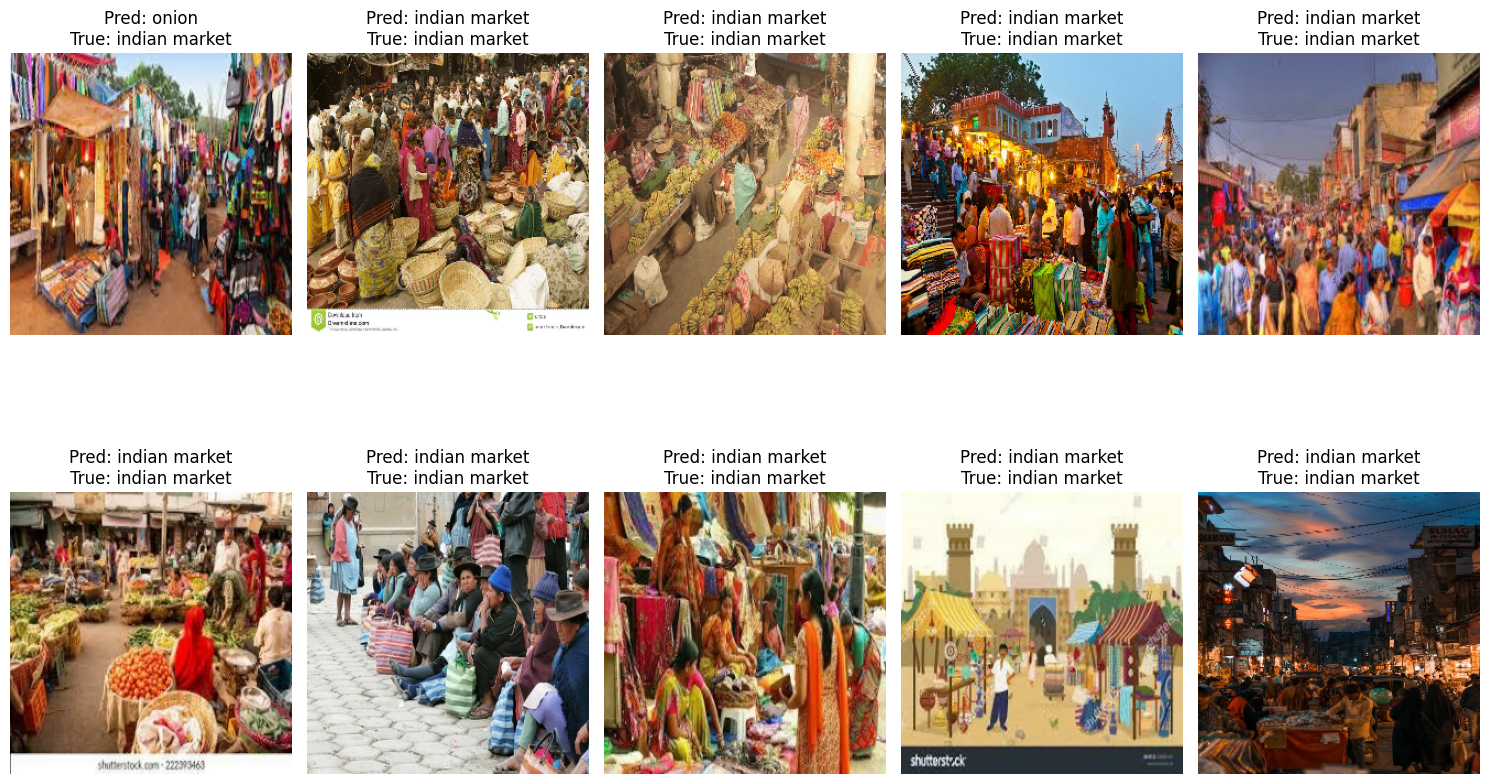

In [58]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Define a function to plot random predictions
def plot_random_predictions(model, test_data, class_names, num_samples=10):
    # Extract images and labels from the test data (fetch a batch)
    test_images = []
    test_labels = []

    # Collecting images from the dataset
    for image_batch, label_batch in test_data.take(1):  # Taking one batch from the test data
        test_images.append(image_batch)
        test_labels.append(label_batch)

    # Flatten the list of images and labels
    test_images = np.concatenate(test_images, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    # Select random indices for predictions
    random_indices = random.sample(range(len(test_images)), num_samples)
    random_images = test_images[random_indices]
    true_labels = test_labels[random_indices]

    # Plot the images and their predicted labels
    plt.figure(figsize=(15, 10))
    for i, img in enumerate(random_images):
        ax = plt.subplot(2, 5, i + 1)

        # Ensure 4D input: (1, height, width, channels)
        img_array = np.expand_dims(img, axis=0)

        # Perform prediction on the image
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=1)[0]
        true_class = np.argmax(true_labels[i])

        # Display the image with predicted and true labels
        plt.imshow(img.astype("uint8"))  # Use the NumPy array directly
        plt.title(f"Pred: {class_names[predicted_class]}\nTrue: {class_names[true_class]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Define the class names in your test dataset
class_names = ['indian market', 'onion', 'potato', 'tomato']

# Call the function to plot random predictions (assuming you have `mob_model` and `test_data`)
plot_random_predictions(mob_model, test_data, class_names)
